# Install wandb

In [1]:
pip install wandb

Note: you may need to restart the kernel to use updated packages.


# 1. Imports and Initial Setup

Importing the necessary libraries and setting a global random seed for reproducibility.


In [2]:
import os
import random
import numpy as np
import pandas as pd
import wandb
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import IPython.display as display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import matplotlib.font_manager as fm
import warnings

# Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


# 2. Data Preprocessing

Load the dataset, build vocabularies, and define helper functions for sequence conversion.

In [3]:
# Load data
def load_data(file_path):
    data = []
    with open(file_path, encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split('\t')
            if len(parts) >= 2:
                bengali, latin = parts[0], parts[1]
                data.append((latin, bengali))
    return data

# Special tokens
PAD_TOKEN = '<pad>'
SOS_TOKEN = '<sos>'
EOS_TOKEN = '<eos>'

# File paths 
train_path = '/kaggle/input/dakshina-dataset-v1-0/bn/lexicons/bn.translit.sampled.train.tsv'
val_path = '/kaggle/input/dakshina-dataset-v1-0/bn/lexicons/bn.translit.sampled.dev.tsv'
test_path = '/kaggle/input/dakshina-dataset-v1-0/bn/lexicons/bn.translit.sampled.test.tsv'

train_data = load_data(train_path)
val_data = load_data(val_path)
test_data = load_data(test_path)

print(f"Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)}")

def build_vocab(sequences):
    chars = sorted(set("".join(sequences)))
    vocab = [PAD_TOKEN, SOS_TOKEN, EOS_TOKEN] + chars
    char2idx = {char: idx for idx, char in enumerate(vocab)}
    idx2char = {idx: char for char, idx in char2idx.items()}
    return char2idx, idx2char

input_texts = [x[0] for x in train_data]
target_texts = [x[1] for x in train_data]

input_char2idx, input_idx2char = build_vocab(input_texts)
target_char2idx, target_idx2char = build_vocab(target_texts)

INPUT_DIM = len(input_char2idx)
OUTPUT_DIM = len(target_char2idx)
PAD_IDX = target_char2idx[PAD_TOKEN]
SOS_IDX = target_char2idx[SOS_TOKEN]
EOS_IDX = target_char2idx[EOS_TOKEN]
max_input_len = max(len(seq) for seq in input_texts)
max_target_len = max(len(seq) for seq in target_texts) + 2  # for <sos> and <eos>

print(f"Input vocab: {INPUT_DIM}, Target vocab: {OUTPUT_DIM}")
print(f"Max input length: {max_input_len}, Max target length: {max_target_len}")


Train: 94546, Val: 9279, Test: 9228
Input vocab: 29, Target vocab: 63
Max input length: 22, Max target length: 24


# 3. Dataset and DataLoader

Define a PyTorch `Dataset` class to handle the sequence-to-sequence data, and instantiate `DataLoader`s for train, validation, and test sets.


In [4]:
# Dataset class
class TransliterationDataset(Dataset):
    def __init__(self, data, input_char2idx, target_char2idx, max_input_len, max_target_len):
        self.data = data
        self.input_char2idx = input_char2idx
        self.target_char2idx = target_char2idx
        self.max_input_len = max_input_len
        self.max_target_len = max_target_len

    def __len__(self):
        return len(self.data)

    def encode_input(self, seq):
        idxs = [self.input_char2idx.get(char, self.input_char2idx[PAD_TOKEN]) for char in seq]
        padding = [self.input_char2idx[PAD_TOKEN]] * (self.max_input_len - len(idxs))
        return torch.tensor(idxs + padding, dtype=torch.long)

    def encode_target(self, seq):
        full_seq = [SOS_TOKEN] + list(seq) + [EOS_TOKEN]
        idxs = [self.target_char2idx.get(char, self.target_char2idx[PAD_TOKEN]) for char in full_seq]
        padding = [self.target_char2idx[PAD_TOKEN]] * (self.max_target_len - len(idxs))
        return torch.tensor(idxs + padding, dtype=torch.long)

    def __getitem__(self, idx):
        latin, bengali = self.data[idx]
        return self.encode_input(latin), self.encode_target(bengali)

batch_size = 64
train_dataset = TransliterationDataset(train_data, input_char2idx, target_char2idx, max_input_len, max_target_len)
val_dataset = TransliterationDataset(val_data, input_char2idx, target_char2idx, max_input_len, max_target_len)
test_dataset = TransliterationDataset(test_data, input_char2idx, target_char2idx, max_input_len, max_target_len)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


# 4. Model Architecture with Attention

Define the Encoder,Attention, Decoder, and Seq2Seq (sequence-to-sequence) models, supporting multiple cell types (RNN, GRU, LSTM) and beam search decoding.


In [5]:
# Encoder
class Encoder(nn.Module):
    def __init__(self, input_size, embed_size, hidden_size, layers=1, dropout=0.5, cell='gru'):
        super().__init__()
        self.embedding = nn.Embedding(input_size, embed_size)
        self.dropout = nn.Dropout(dropout)
        rnn = {'lstm': nn.LSTM, 'gru': nn.GRU, 'rnn': nn.RNN}[cell]
        self.rnn = rnn(embed_size, hidden_size, layers, dropout=dropout if layers > 1 else 0, batch_first=True)
        self.cell = cell
        self.hidden_size = hidden_size
        self.layers = layers

    def forward(self, x):
        embedded = self.dropout(self.embedding(x))
        outputs, hidden = self.rnn(embedded)               
        return outputs, hidden                             

class Attention(nn.Module):
    def __init__(self, enc_hidden_dim, dec_hidden_dim):
        super().__init__()
        self.attn = nn.Linear(enc_hidden_dim + dec_hidden_dim, dec_hidden_dim)
        self.v = nn.Parameter(torch.rand(dec_hidden_dim))

    def forward(self, hidden, encoder_outputs, mask=None):
        src_len = encoder_outputs.size(1)
        h = hidden.unsqueeze(1).repeat(1, src_len, 1)      
        energy = torch.tanh(self.attn(torch.cat((h, encoder_outputs), dim=2)))
        energy = energy @ self.v
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        attn_weights = F.softmax(energy, dim=1)        
        return attn_weights

class Decoder(nn.Module):
    def __init__(self, output_size, embed_size, enc_hidden_size, dec_hidden_size, attention, layers=1, dropout=0.5, cell='gru'):
        super().__init__()
        self.output_size = output_size
        self.embedding = nn.Embedding(output_size, embed_size)
        self.dropout = nn.Dropout(dropout)
        self.attention = attention
        self.celltype = cell
        rnn = {'lstm': nn.LSTM, 'gru': nn.GRU, 'rnn': nn.RNN}[cell]
        self.rnn = rnn(embed_size + enc_hidden_size, dec_hidden_size, layers, dropout=dropout if layers>1 else 0, batch_first=True)
        self.fc_out = nn.Linear(enc_hidden_size + dec_hidden_size + embed_size, output_size)

    def forward(self, input, hidden, encoder_outputs, mask=None):
        input = input.unsqueeze(1)                                   
        embed = self.dropout(self.embedding(input))                  
        # Attention uses only top layer hidden
        if isinstance(hidden, tuple):   
            dec_hidden = hidden[0][-1]  
        else:                           
            dec_hidden = hidden[-1]
        attn_weights = self.attention(dec_hidden, encoder_outputs, mask)    
        attn_weights = attn_weights.unsqueeze(1)                     
        context = torch.bmm(attn_weights, encoder_outputs)           
        rnn_input = torch.cat((embed, context), dim=2)               
        output, hidden = self.rnn(rnn_input, hidden)                 
        output = output.squeeze(1)                                   
        context = context.squeeze(1)                                 
        embed = embed.squeeze(1)                                     
        out = self.fc_out(torch.cat((output, context, embed), dim=1))
        return out, hidden, attn_weights.squeeze(1)

    def beam_search(self, hidden, encoder_outputs, beam_width, sos_idx, eos_idx, max_len, device):
        sequences = [([sos_idx], hidden, 0.0)]
        for _ in range(max_len):
            candidates = []
            for seq, h, score in sequences:
                if seq[-1] == eos_idx:
                    candidates.append((seq, h, score))
                    continue
                input_token = torch.tensor([seq[-1]], device=device)
                out, h_new, _ = self.forward(input_token, h, encoder_outputs)
                log_probs = F.log_softmax(out, dim=1).squeeze(0)
                top_log_probs, top_tokens = torch.topk(log_probs, beam_width)
                for i in range(beam_width):
                    candidate = seq + [top_tokens[i].item()]
                    candidate_score = score + top_log_probs[i].item()
                    candidates.append((candidate, h_new, candidate_score))
            sequences = sorted(candidates, key=lambda x: x[2], reverse=True)[:beam_width]
            if all(seq[-1] == eos_idx for seq,_,_ in sequences):
                break
        return sequences[0][0], sequences[0][2]

def adjust_hidden_state(enc_hidden, enc_layers, dec_layers, hidden_size, cell):
    def pad_tensor(tensor):
        if dec_layers == enc_layers:
            return tensor
        batch_size = tensor.size(1)
        device = tensor.device
        extra = torch.zeros(abs(dec_layers - enc_layers), batch_size, hidden_size, device=device)
        return torch.cat([tensor, extra], dim=0) if dec_layers > enc_layers else tensor[-dec_layers:]
    if cell == 'lstm':
        return (pad_tensor(enc_hidden[0]), pad_tensor(enc_hidden[1]))
    return pad_tensor(enc_hidden)

class Seq2Seq(nn.Module):
    def __init__(self, input_size, output_size, embed_size, hidden_size, enc_layers=1, dec_layers=1, dropout=0.3, cell='gru'):
        super().__init__()
        self.encoder = Encoder(input_size, embed_size, hidden_size, enc_layers, dropout, cell)
        self.attention = Attention(hidden_size, hidden_size)
        self.decoder = Decoder(output_size, embed_size, hidden_size, hidden_size, self.attention, dec_layers, dropout, cell)
        self.enc_layers = enc_layers
        self.dec_layers = dec_layers
        self.hidden_size = hidden_size
        self.cell = cell
        self.output_size = output_size

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size, trg_len = trg.size()
        outputs = torch.zeros(batch_size, trg_len, self.output_size, device=src.device)
        encoder_outputs, enc_hidden = self.encoder(src)     
        dec_hidden = adjust_hidden_state(enc_hidden, self.enc_layers, self.dec_layers, self.hidden_size, self.cell)
        dec_input = trg[:, 0]
        for t in range(1, trg_len):
            output, dec_hidden, _ = self.decoder(dec_input, dec_hidden, encoder_outputs)
            outputs[:, t] = output
            top1 = output.argmax(1)
            dec_input = trg[:, t] if random.random() < teacher_forcing_ratio else top1
        return outputs

    def inference_beam_search(self, src, beam_width, sos_idx, eos_idx, max_len, device):
        self.eval()
        with torch.no_grad():
            encoder_outputs, enc_hidden = self.encoder(src)
            dec_hidden = adjust_hidden_state(enc_hidden, self.enc_layers, self.dec_layers, self.hidden_size, self.cell)
            return self.decoder.beam_search(dec_hidden, encoder_outputs, beam_width, sos_idx, eos_idx, max_len, device)


# 5. Training and Evaluation Functions

Standard training, validation, and test routines for sequence-to-sequence models. Metrics and loss are computed and returned for each batch.


In [6]:
# Train and evaluate
def train_epoch(model, dataloader, optimizer, criterion, device, clip=1.0):
    model.train()
    total_loss = 0
    for src, trg in dataloader:
        src, trg = src.to(device), trg.to(device)
        optimizer.zero_grad()
        output = model(src, trg)
        output = output[:, 1:].reshape(-1, output.shape[-1])
        trg = trg[:, 1:].reshape(-1)
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for src, trg in dataloader:
            src, trg = src.to(device), trg.to(device)
            output = model(src, trg, teacher_forcing_ratio=0)
            output = output[:, 1:].reshape(-1, output.shape[-1])
            trg = trg[:, 1:].reshape(-1)
            total_loss += criterion(output, trg).item()
    return total_loss / len(dataloader)

def sequence_accuracy(model, dataloader, target_idx2char, device):
    model.eval()
    total, correct = 0, 0
    with torch.no_grad():
        for src, trg in dataloader:
            src, trg = src.to(device), trg.to(device)
            for i in range(src.size(0)):
                input_seq = src[i].unsqueeze(0)
                pred_seq, _ = model.inference_beam_search(input_seq, beam_width=3, sos_idx=SOS_IDX, eos_idx=EOS_IDX, max_len=trg.size(1), device=device)
                pred_str = ''.join([target_idx2char[idx] for idx in pred_seq if idx not in (PAD_IDX, SOS_IDX, EOS_IDX)])
                true_str = ''.join([target_idx2char[idx] for idx in trg[i].tolist() if idx not in (PAD_IDX, SOS_IDX, EOS_IDX)])
                correct += (pred_str == true_str)
                total += 1
    return correct/total

# 6. Main Training Loop with Weights & Biases (W&B)

The `main` function can be used both for single runs and as part of W&B hyperparameter sweeps.  
It logs results to W&B and saves the best model by validation accuracy.


In [7]:
def main():
    wandb.init()
    config = wandb.config
    run_name = f"emb{config.emb_dim}_hid{config.hidden_dim}_enc{config.encoder_layers}_dec{config.decoder_layers}_drop{config.dropout}_{config.cell}_beam{config.beam_size}"
    wandb.run.name = run_name
    model = Seq2Seq(
        input_size=INPUT_DIM,
        output_size=OUTPUT_DIM,
        embed_size=config.emb_dim,
        hidden_size=config.hidden_dim,
        enc_layers=config.encoder_layers,
        dec_layers=config.decoder_layers,
        dropout=config.dropout,
        cell=config.cell.lower()
    ).to(device)
    optimizer = torch.optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

    for epoch in range(5):
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
        #train_acc = sequence_accuracy(model, train_loader, target_idx2char, device)
        val_loss = evaluate(model, val_loader, criterion, device)
        val_acc = sequence_accuracy(model, val_loader, target_idx2char, device)
        wandb.log({
            "epoch": epoch+1,
            "train_loss": train_loss,
            #"train_accuracy":train_acc,
            "val_loss": val_loss,
            "val_accuracy": val_acc
        })
        print(f"Epoch [{epoch+1}/5], Val Accuracy: {val_acc:.4f}")
    model_path = f"model_{wandb.run.id}.pth"
    torch.save(model.state_dict(), model_path)
    wandb.save(model_path)


# 7. Log in to W&B Account

Login into my W&B Account with API Key

In [8]:
import wandb
wandb.login(key='150002a34bcf7d04848ccaff65ab76ca5cc3f11b')

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ma24m025 (ma24m025-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

# 8. Weights & Biases Sweep Configuration

Set up a Bayesian parameter sweep for hyperparameter tuning with early stopping.


In [ ]:
# Sweep Config
sweep_config = {
    'method': "bayes",
    'metric': {'name': 'val_accuracy', 'goal': 'maximize'},
    'early_terminate': {'type': "hyperband", 'min_iter': 3},
    'parameters': {
        'emb_dim': {'values': [16, 32, 64, 128, 256]},
        'hidden_dim': {'values': [16, 32, 64, 128, 256]},
        'encoder_layers': {'values': [1, 2, 3]},
        'decoder_layers': {'values': [1, 2, 3]},
        'dropout': {'values': [0.2, 0.3]},
        'cell': {'values': ['RNN', 'GRU', 'LSTM']},
        'beam_size': {'values': [1, 3, 5]}
    }
}

if __name__ == '__main__':
    sweep_id = wandb.sweep(sweep_config, project="dakshina-seq2seq-attn")
    wandb.agent(sweep_id, function=main, count=19)



# 9. Load Best Model and Evaluate on Test Set & Save Predictions

### Load the best model from sweep, evaluate on test set,
### generate sample predictions, and save them to CSV file.

In [9]:
# Initialize API
api = wandb.Api()
# Sweep path
sweep_path = f"ma24m025-indian-institute-of-technology-madras/dakshina-seq2seq-attn/sweeps/6qdndkb6" #{sweep_id}"
# sweep_path = "your_username/dakshina-seq2seq/sweeps/your_sweep_id" 

# Get best run & Corrosponding config
sweep = api.sweep(sweep_path)
best_run = sweep.best_run(order='val_accuracy')
best_config = best_run.config

# Print all details
print(f"Best Run ID: {best_run.id}")
print(f"Best Validation Accuracy: {best_run.summary['val_accuracy']:.4f}")
print("Best Hyperparameters:")
print(best_config)

wandb: Sorting runs by -summary_metrics.val_accuracy


Best Run ID: e2cfbjb8
Best Validation Accuracy: 0.3915
Best Hyperparameters:
{'cell': 'LSTM', 'dropout': 0.2, 'emb_dim': 128, 'beam_size': 3, 'hidden_dim': 256, 'decoder_layers': 3, 'encoder_layers': 2}


In [10]:
# Initialize the model architecture with the best run's hyperparameters
best_model = Seq2Seq(
    input_size=INPUT_DIM,
    output_size=OUTPUT_DIM,
    embed_size=best_config['emb_dim'],
    hidden_size=best_config['hidden_dim'],
    enc_layers=best_config['encoder_layers'],
    dec_layers=best_config['decoder_layers'],
    dropout=best_config['dropout'],
    cell=best_config['cell'].lower()
).to(device)

# Use best hyperparams & load best model weights
model_file_name = f"model_{best_run.id}.pth"
best_model_file = best_run.file(model_file_name)
best_model_file.download(replace=True)

# Load the state dict
best_model.load_state_dict(
    torch.load(model_file_name, map_location=device)
)


<All keys matched successfully>

In [ ]:
# Initialize the model architecture with the best run's hyperparameters
best_model = Seq2Seq(
    input_size=INPUT_DIM,
    output_size=OUTPUT_DIM,
    embed_size=best_config['emb_dim'],
    hidden_size=best_config['hidden_dim'],
    enc_layers=best_config['encoder_layers'],
    dec_layers=best_config['decoder_layers'],
    dropout=best_config['dropout'],
    cell=best_config['cell'].lower()
).to(device)

# Use best hyperparams & load best model weights
model_file_name = f"model_{best_run.id}.pth"
best_model_file = best_run.file(model_file_name)
best_model_file.download(replace=True)

# Load the state dict
best_model.load_state_dict(
    torch.load(model_file_name, map_location=device)
)

# Print best test accuracy
best_model.eval()
test_acc = sequence_accuracy(best_model, test_loader, target_idx2char, device)
print(f"Test Accuracy (exact sequence match): {test_acc:.4f}")


### Display the prediction and save to csv file 

In [13]:
# Decode Sequence
def decode_sequence(seq, idx2char):
    chars = []
    for idx in seq:
        if idx2char[idx] == '<eos>':
            break
        if idx2char[idx] not in ['<pad>', '<sos>']:
            chars.append(idx2char[idx])
    return ''.join(chars)


In [ ]:
# Decode Sequence
def decode_sequence(seq, idx2char):
    chars = []
    for idx in seq:
        if idx2char[idx] == '<eos>':
            break
        if idx2char[idx] not in ['<pad>', '<sos>']:
            chars.append(idx2char[idx])
    return ''.join(chars)

samples = []
best_model.eval()

with torch.no_grad():
    for i in range(len(test_dataset)):
        src, trg = test_dataset[i]
        src = src.unsqueeze(0).to(device)
        trg = trg.unsqueeze(0).to(device)

        outputs = best_model(src, trg, teacher_forcing_ratio=0)
        preds = outputs.argmax(dim=2)

        input_seq = decode_sequence(src[0].cpu().numpy(), input_idx2char)
        target_seq = decode_sequence(trg[0].cpu().numpy(), target_idx2char)
        pred_seq = decode_sequence(preds[0].cpu().numpy(), target_idx2char)

        samples.append((input_seq, target_seq, pred_seq))

df_samples = pd.DataFrame(samples, columns=['Input_Latin', 'Target_Bengali', 'Predicted_Bengali'])
df_samples.to_csv("/kaggle/working/predictions_attention.csv", index=False)
print("Sample predictions saved to predictions_attension.csv")

# Show 10 random samples
display.display(df_samples.sample(10))

# 10.Attention Heatmap

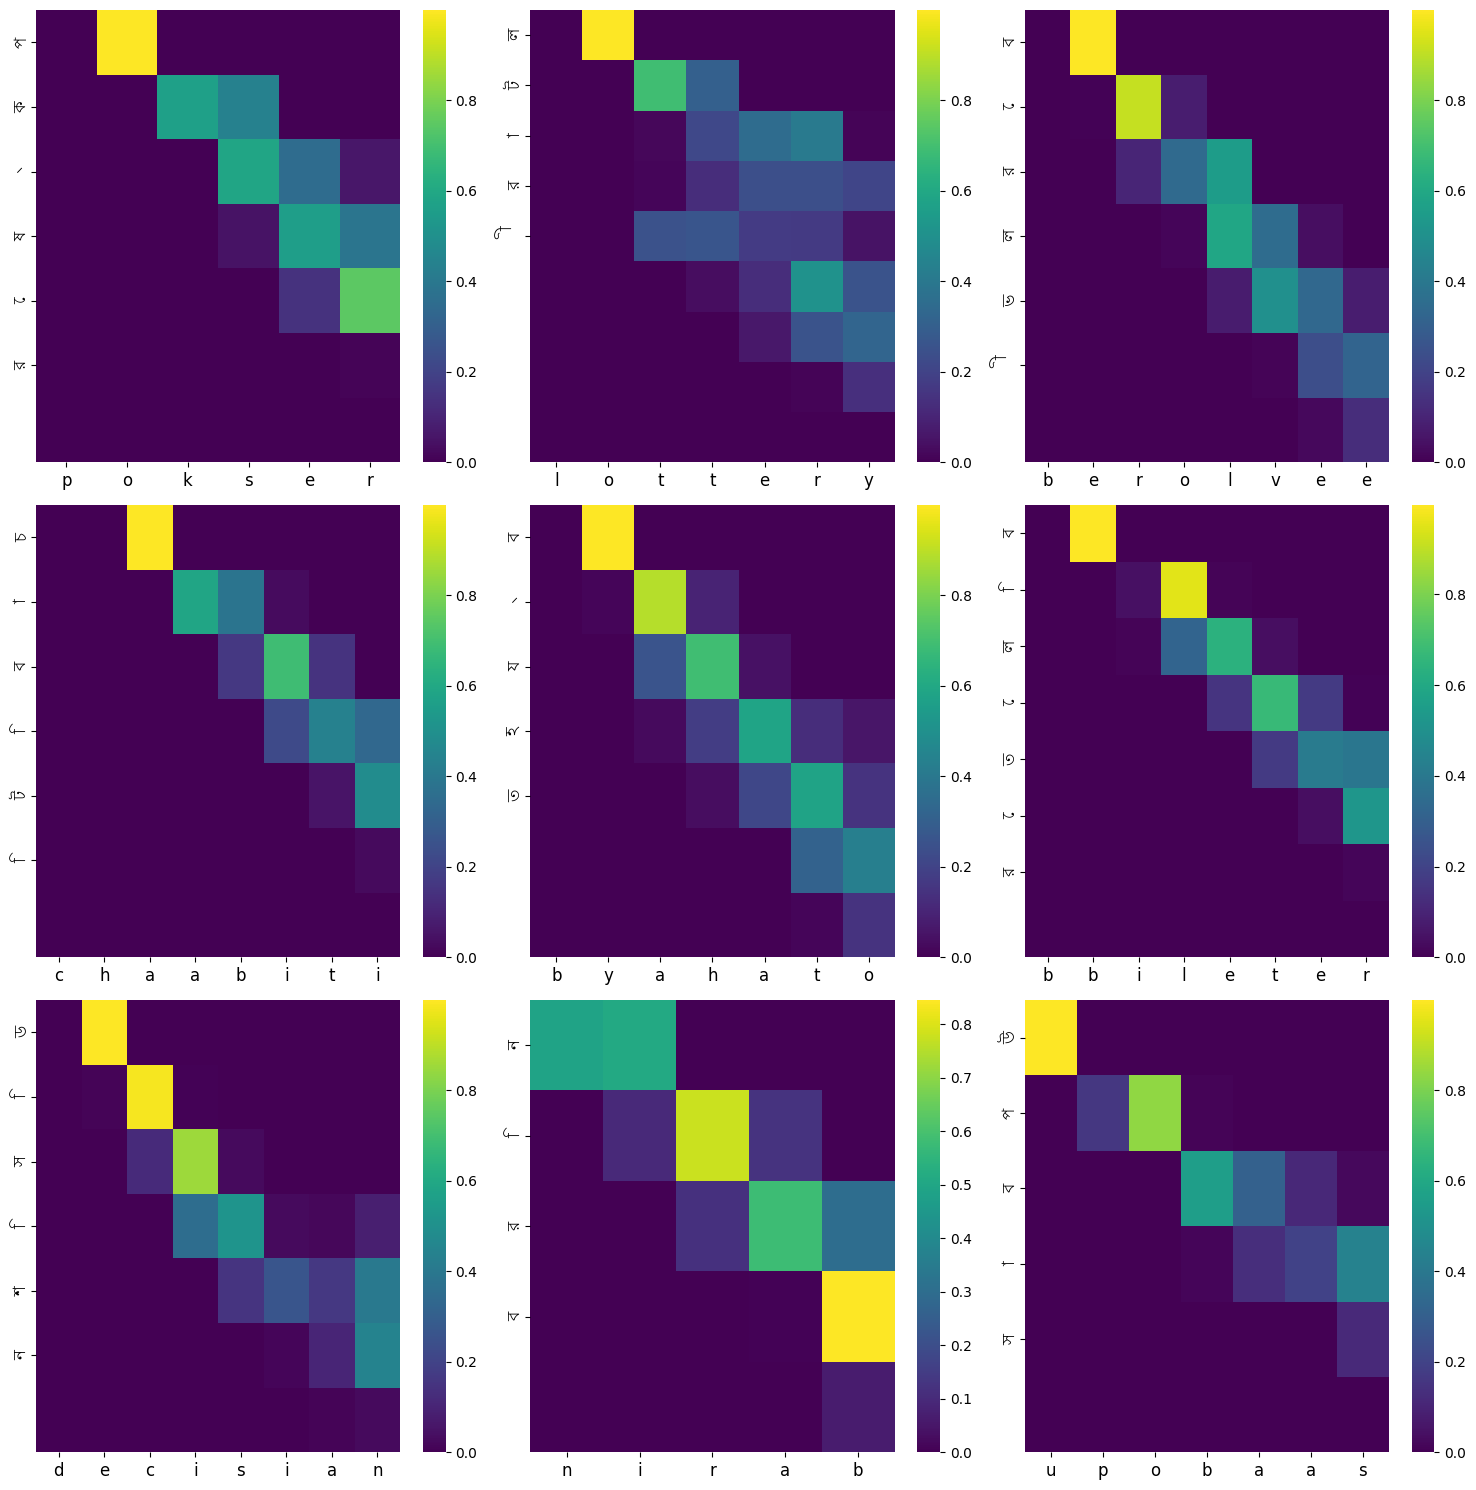

In [34]:
# Ignore warning
warnings.filterwarnings("ignore")

# Load Bengali font
bengali_font = fm.FontProperties(fname='/kaggle/input/lohit-bn/Lohit-Bengali.ttf')

# Function to check if text contains Bengali characters
def contains_bengali(text):
    return any('\u0980' <= ch <= '\u09FF' for ch in str(text))

# Select 9 random indices from the test dataset
random_indices = random.sample(range(len(test_dataset)), 9)

# Plot 9 random examples in a 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

def get_attention_weights(model, src, max_len, device):
    model.eval()
    with torch.no_grad():
        encoder_outputs, enc_hidden = model.encoder(src)
        dec_hidden = adjust_hidden_state(enc_hidden, model.enc_layers, model.dec_layers, model.hidden_size, model.cell)
        dec_input = torch.tensor([SOS_IDX], device=device)
        attn_weights = []
        for _ in range(max_len):
            output, dec_hidden, attn = model.decoder(dec_input, dec_hidden, encoder_outputs)
            attn_weights.append(attn.squeeze(0).cpu().numpy())
            dec_input = output.argmax(1)
            if dec_input.item() == EOS_IDX:
                break
        return np.array(attn_weights)

for i, idx in enumerate(random_indices):
    src, trg = test_dataset[idx]
    src = src.unsqueeze(0).to(device)
    input_seq = decode_sequence(src[0].cpu().numpy(), input_idx2char)
    target_seq = decode_sequence(trg.cpu().numpy(), target_idx2char)
    attn_weights = get_attention_weights(best_model, src, max_len=max_target_len, device=device)
    
    sns.heatmap(attn_weights[:, :len(input_seq)], 
                xticklabels=list(input_seq), 
                yticklabels=list(target_seq)[:attn_weights.shape[0]], 
                cmap='viridis', ax=axes[i])
    
    # Set font for Bengali ticks only
    for label in axes[i].get_xticklabels() + axes[i].get_yticklabels():
        if contains_bengali(label.get_text()):
            label.set_fontproperties(bengali_font)
        label.set_fontsize(12)

plt.tight_layout()
# Save the plot with full path in Kaggle working directory
plt.savefig("/kaggle/working/heatmap_attension.png", dpi=300, bbox_inches='tight')
plt.show()


# 11.Visualization Conectivity

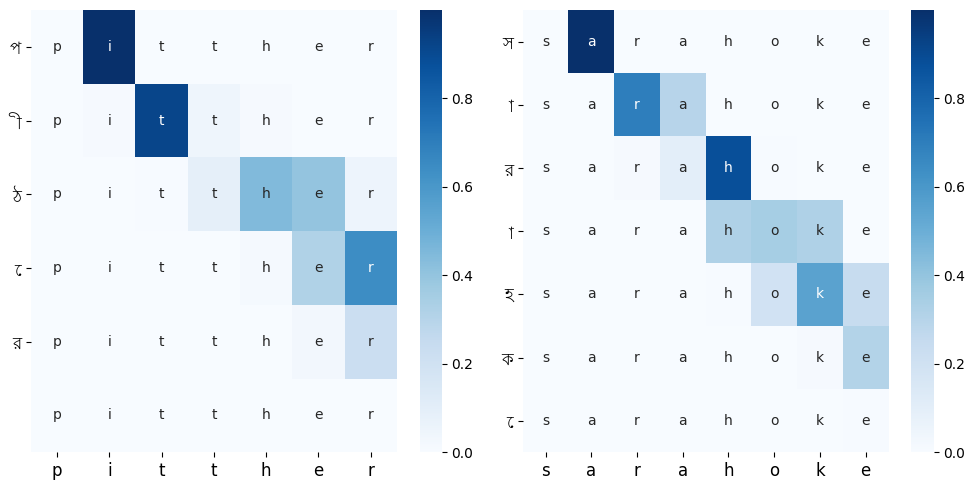

In [54]:
# Define Visualize Conectivity
def visualize_connectivity(model, dataset, idx2char_input, idx2char_target, device, num_examples=4):
    model.eval()
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes = axes.flatten()

    # Sample random indices from the dataset
    indices = random.sample(range(len(dataset)), num_examples)

    for i, idx in enumerate(indices):
        src, trg = dataset[idx]
        src = src.unsqueeze(0).to(device)

        # Get attention weights
        attn_weights = get_attention_weights(model, src, max_len=max_target_len, device=device)

        # Decode sequences for labels
        input_seq = decode_sequence(src[0].cpu().numpy(), idx2char_input)
        target_seq = decode_sequence(trg.cpu().numpy(), idx2char_target)

        # Prepare attention matrix and character annotations
        heatmap_data = attn_weights[:, :len(input_seq)]
        char_matrix = np.array([list(input_seq[:heatmap_data.shape[1]])] * heatmap_data.shape[0])

        # Plot heatmap
        sns.heatmap(heatmap_data,
                    xticklabels=list(input_seq),
                    yticklabels=list(target_seq)[:heatmap_data.shape[0]],
                    cmap='Blues',
                    annot=char_matrix,
                    fmt='',
                    ax=axes[i])

        # Format y-axis (target sequence)
        for label in axes[i].get_yticklabels():
            if contains_bengali(label.get_text()):
                label.set_fontproperties(bengali_font)
            label.set_fontsize(12)
            label.set_rotation(0)

        # Format x-axis (input sequence)
        for label in axes[i].get_xticklabels():
            if contains_bengali(label.get_text()):
                label.set_fontproperties(bengali_font)
            label.set_fontsize(12)

    plt.tight_layout()
    plt.savefig("/kaggle/working/visualize_connectivity.png", dpi=300, bbox_inches='tight')
    plt.show()

visualize_connectivity(best_model, test_dataset, input_idx2char, target_idx2char, device, num_examples=2)


# The End!
#### Thank You.